# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import random

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [12]:
words = Counter()
proccessed_text_test_list = [] # взглянем на предложения после процессинга, но до токенизации

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    # Заменим пунктуацию на пробелы (кажется так будет лучше для слов через "-" или "/", но без пробелов перед этими знаками)
    prccessed_text = example.lower().translate(
        str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    proccessed_text_test_list.append(prccessed_text)

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# counter_threshold = 25
counter_threshold = 10

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 18641


### Рандомное предложение до и после предобработки:

In [14]:
index = random.randint(0, 1000)
# index = 612
print(f'index = {index}')
print(len(dataset['train'][index]['text']))
print(dataset['train'][index]['text'])
print(len(proccessed_text_test_list[index]))
print(proccessed_text_test_list[index])

index = 671
208
Lucrative Cash Package Came as Fairchild Reported \$53.2 Million Loss  For Jeffrey J. Steiner, chairman and chief executive of Fairchild Corp., nearly \$2.5 million in salary last year was just the beginning.
208
lucrative cash package came as fairchild reported   53 2 million loss  for jeffrey j  steiner  chairman and chief executive of fairchild corp   nearly   2 5 million in salary last year was just the beginning 


In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
        str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [16]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [26]:
test_idx = list(set(np.arange(len(dataset['test']))) - set(idx))
test_dataset = WordDataset(dataset['test'].select(test_idx))
test_dataloader = DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

### Рандомное предложение до и после токенизации:

In [17]:
print(len(dataset['train'][index]['text']))
print(dataset['train'][index]['text'])
print(len(proccessed_text_test_list[index]))
print((proccessed_text_test_list[index]))
print(len(train_dataset[index]['text']))
print(list(map(ind2word.get, train_dataset[index]['text'])))

208
Lucrative Cash Package Came as Fairchild Reported \$53.2 Million Loss  For Jeffrey J. Steiner, chairman and chief executive of Fairchild Corp., nearly \$2.5 million in salary last year was just the beginning.
208
lucrative cash package came as fairchild reported   53 2 million loss  for jeffrey j  steiner  chairman and chief executive of fairchild corp   nearly   2 5 million in salary last year was just the beginning 
36
['<bos>', 'lucrative', 'cash', 'package', 'came', 'as', '<unk>', 'reported', '53', '2', 'million', 'loss', 'for', 'jeffrey', 'j', '<unk>', 'chairman', 'and', 'chief', 'executive', 'of', '<unk>', 'corp', 'nearly', '2', '5', 'million', 'in', 'salary', 'last', 'year', 'was', 'just', 'the', 'beginning', '<eos>']


## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [27]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# ------------------------------------------------- Baseline CharLM model --------------------------------------------

In [41]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.RNN(embeding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, embeding_len]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [42]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

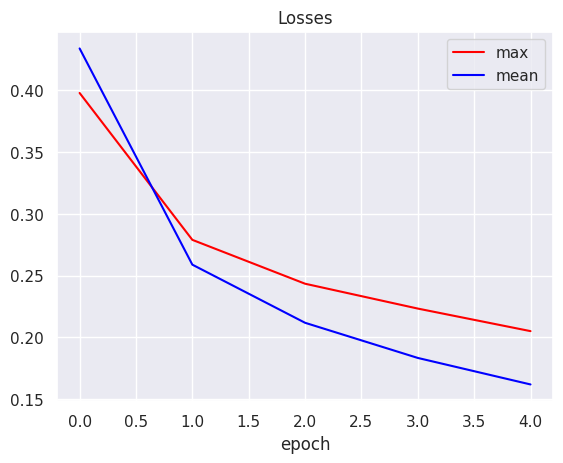

In [43]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.44
Лучшая accuracy для подхода mean: 91.08


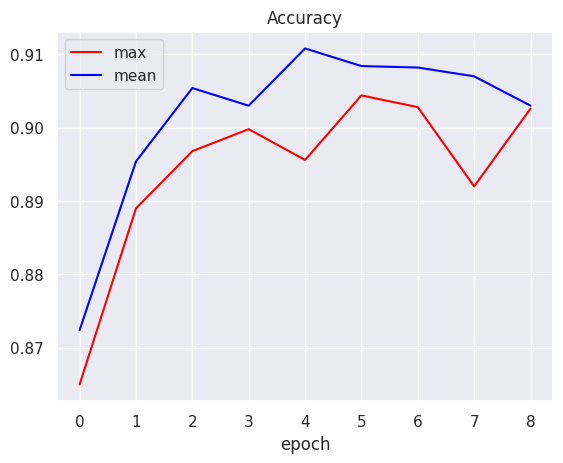

In [44]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# -------------------------------------------------------- Experiments --------------------------------------------------------

## ------------------------------------------------------------------- GRU -------------------------------------------------------------------

In [45]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [47]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU = {}
acc_type_GRU = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU = CharLM_GRU(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU.eval()
                acc.append(evaluate(model_GRU, eval_dataloader))
                model_GRU.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU[aggregation_type] = losses
    acc_type_GRU[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

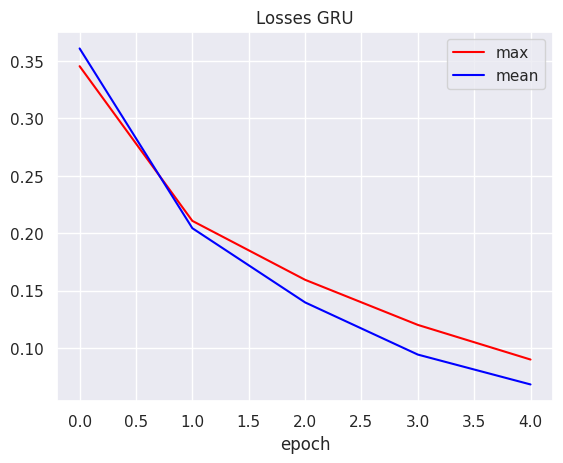

In [48]:
for (name, values), color in zip(losses_type_GRU.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU[name])), losses_type_GRU[name], color=color, label=name)

plt.title('Losses GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.48
Лучшая accuracy для подхода mean: 91.36


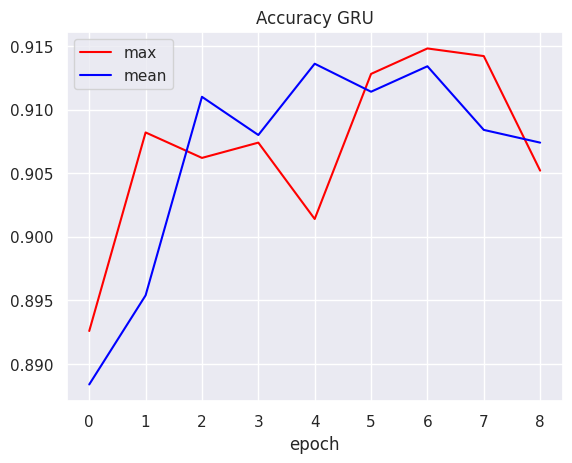

In [49]:
for (name, values), color in zip(losses_type_GRU.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU[name][1:])), acc_type_GRU[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU[name]) * 100):.2f}")

plt.title('Accuracy GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

## ------------------------------------------------------------------- LSTM -------------------------------------------------------------------

In [50]:
class CharLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.LSTM(embeding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [51]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM = {}
acc_type_LSTM = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM = CharLM_LSTM(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM.eval()
                acc.append(evaluate(model_LSTM, eval_dataloader))
                model_LSTM.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM[aggregation_type] = losses
    acc_type_LSTM[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

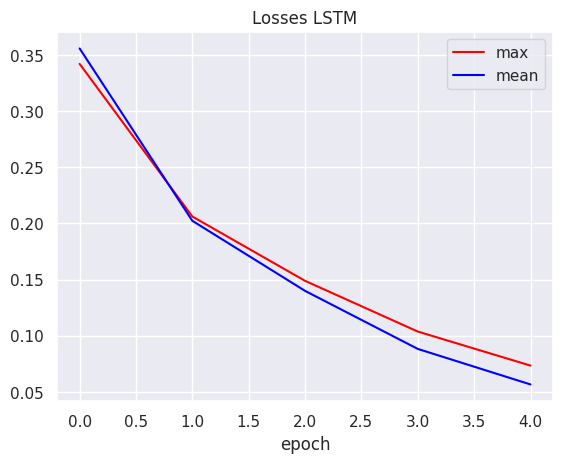

In [52]:
for (name, values), color in zip(losses_type_LSTM.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM[name])), losses_type_LSTM[name], color=color, label=name)

plt.title('Losses LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.60
Лучшая accuracy для подхода mean: 92.30


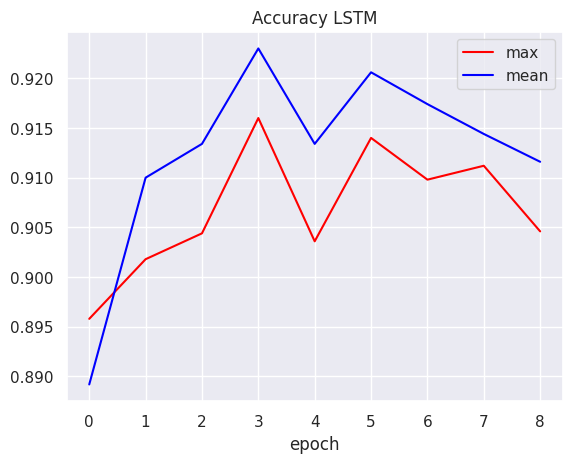

In [53]:
for (name, values), color in zip(losses_type_LSTM.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM[name][1:])), acc_type_LSTM[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM[name]) * 100):.2f}")

plt.title('Accuracy LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

## --------------------------------------------------- GRU mean agg N layers -------------------------------------------------

In [55]:
class CharLM_GRU_N_layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [56]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_Nl = {}
acc_type_GRU_Nl = {}

# for aggregation_type in ['max', 'mean']:
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_Nl = CharLM_GRU_N_layers(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type, N_layers=3).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_Nl.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_Nl.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_Nl(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_Nl.eval()
                acc.append(evaluate(model_GRU_Nl, eval_dataloader))
                model_GRU_Nl.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_Nl[aggregation_type] = losses
    acc_type_GRU_Nl[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

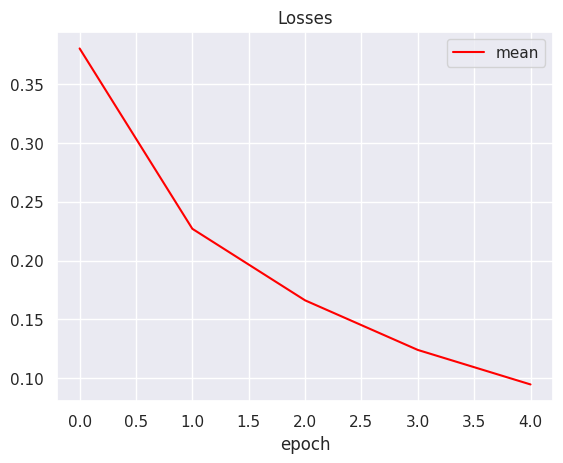

In [57]:
for (name, values), color in zip(losses_type_GRU_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_Nl[name])), losses_type_GRU_Nl[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.64


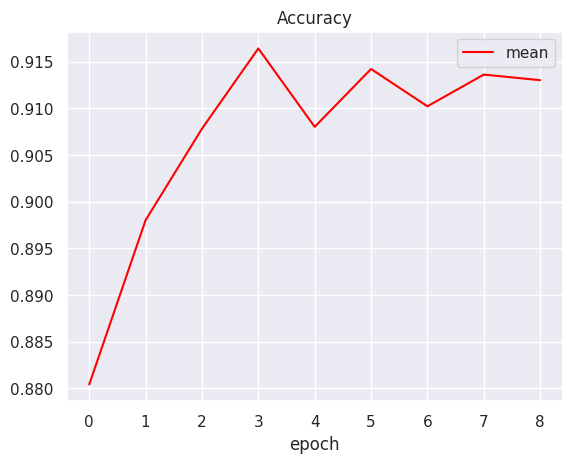

In [58]:
for (name, values), color in zip(losses_type_GRU_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_Nl[name][1:])), acc_type_GRU_Nl[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_Nl[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

## --------------------------------------------------- LSTM mean agg N layers -------------------------------------------------

In [59]:
class CharLM_LSTM_N_layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.LSTM(embeding_len, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [60]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_Nl = {}
acc_type_LSTM_Nl = {}

# for aggregation_type in ['max', 'mean']:
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_Nl = CharLM_LSTM_N_layers(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type, N_layers=3).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_Nl.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_Nl.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_Nl(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_Nl.eval()
                acc.append(evaluate(model_LSTM_Nl, eval_dataloader))
                model_LSTM_Nl.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_Nl[aggregation_type] = losses
    acc_type_LSTM_Nl[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

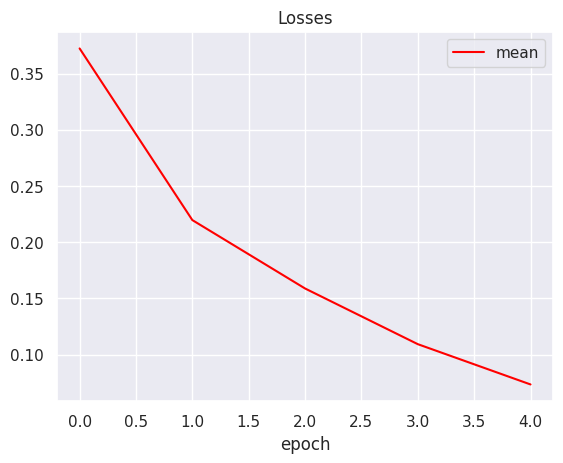

In [61]:
for (name, values), color in zip(losses_type_LSTM_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_Nl[name])), losses_type_LSTM_Nl[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 92.00


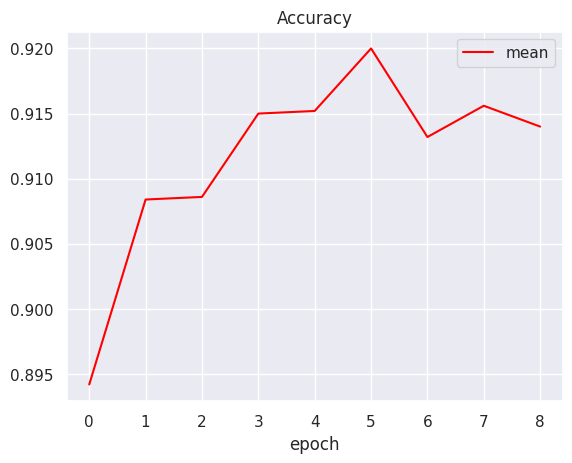

In [62]:
for (name, values), color in zip(losses_type_LSTM_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_Nl[name][1:])), acc_type_LSTM_Nl[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_Nl[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# ------------------------------------ bidirectional GRU ---------------------------

In [65]:
class CharLM_GRU_bd(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [68]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_bd = {}
acc_type_GRU_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_bd = CharLM_GRU_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_bd.eval()
                acc_now = evaluate(model_GRU_bd, eval_dataloader)
                acc.append(acc_now)
                model_GRU_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_bd[aggregation_type] = losses
    acc_type_GRU_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 10min 56s, sys: 6.85 s, total: 11min 3s
Wall time: 11min 35s


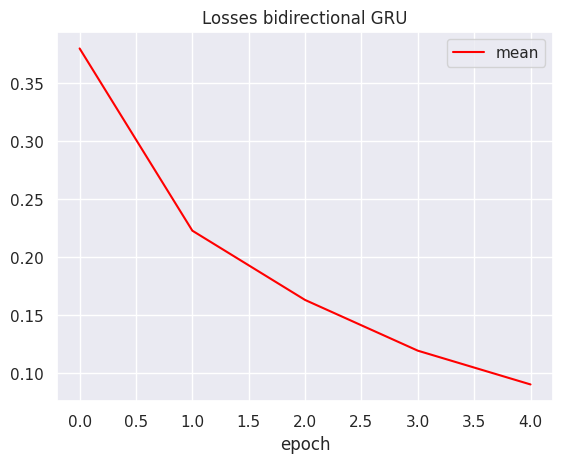

In [69]:
for (name, values), color in zip(losses_type_GRU_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_bd[name])), losses_type_GRU_bd[name], color=color, label=name)

plt.title('Losses bidirectional GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.62


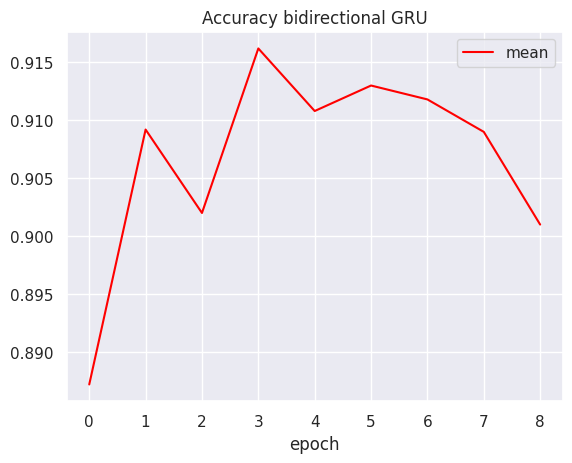

In [70]:
for (name, values), color in zip(losses_type_GRU_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_bd[name][1:])), acc_type_GRU_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

# ------------------------------------ bidirectional LSTM ---------------------------

In [29]:
class CharLM_LSTM_bd(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.LSTM(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [72]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_bd = {}
acc_type_LSTM_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_bd.eval()
                acc_now = evaluate(model_LSTM_bd, eval_dataloader)
                acc.append(acc_now)
                model_LSTM_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_bd[aggregation_type] = losses
    acc_type_LSTM_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 11min 57s, sys: 7.91 s, total: 12min 5s
Wall time: 12min 24s


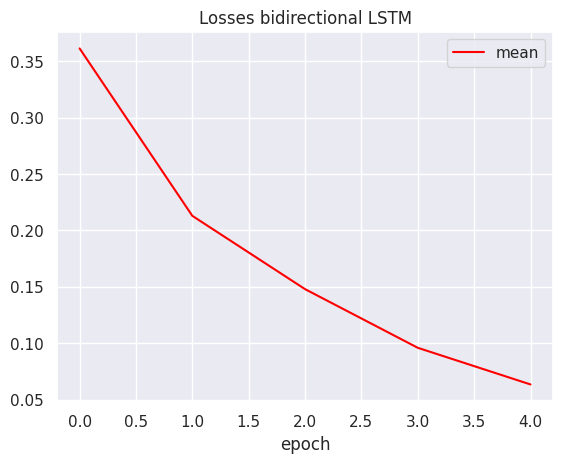

In [73]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_bd[name])), losses_type_LSTM_bd[name], color=color, label=name)

plt.title('Losses bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.82


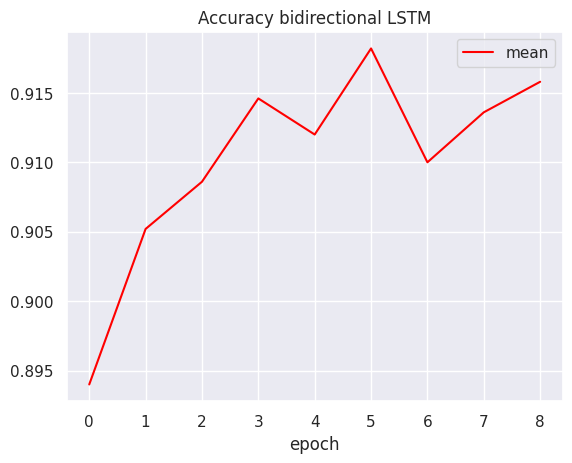

In [74]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_bd[name][1:])), acc_type_LSTM_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Попробуем уменьшить размер эмбединга с 256 до 64 для 3-слойной bidirectional LSTM

In [75]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_bd = {}
acc_type_LSTM_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_bd.eval()
                acc_now = evaluate(model_LSTM_bd, eval_dataloader)
                acc.append(acc_now)
                model_LSTM_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_bd[aggregation_type] = losses
    acc_type_LSTM_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 11min 28s, sys: 7.43 s, total: 11min 35s
Wall time: 11min 56s


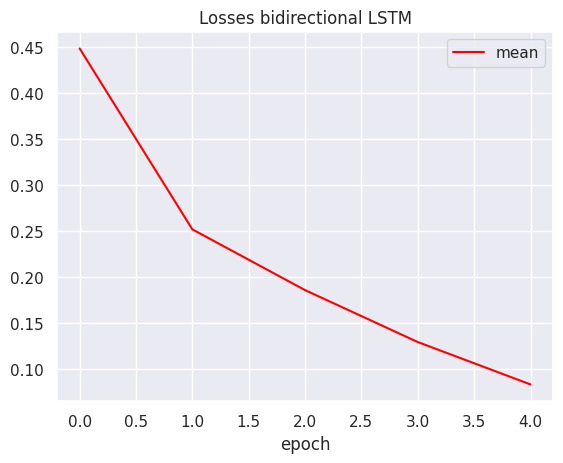

In [76]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_bd[name])), losses_type_LSTM_bd[name], color=color, label=name)

plt.title('Losses bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.70


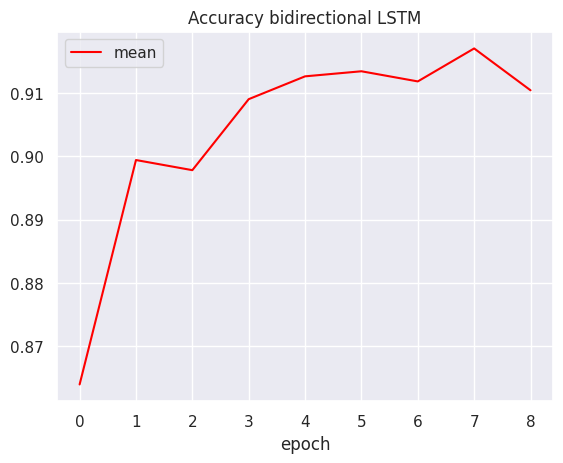

In [77]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_bd[name][1:])), acc_type_LSTM_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Слегка увеличим дропаут с 0.1 до 0.2

In [31]:
model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.2, bd=True, aggregation_type=aggregation_type).to(device)

In [32]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_bd = {}
acc_type_LSTM_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.2, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_bd.eval()
                acc_now = evaluate(model_LSTM_bd, eval_dataloader)
                acc.append(acc_now)
                model_LSTM_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_bd[aggregation_type] = losses
    acc_type_LSTM_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 11min 45s, sys: 9.03 s, total: 11min 54s
Wall time: 12min 15s


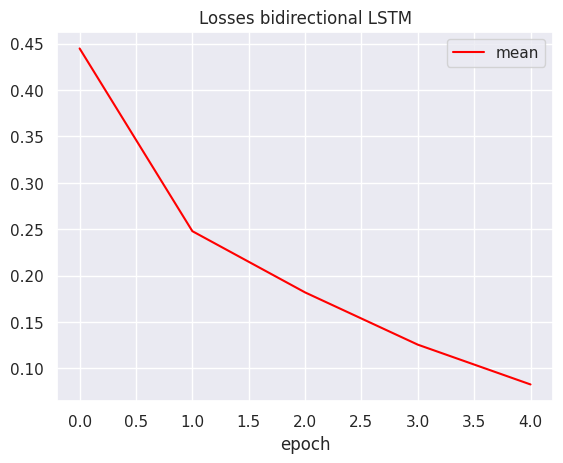

In [34]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_bd[name])), losses_type_LSTM_bd[name], color=color, label=name)

plt.title('Losses bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.78


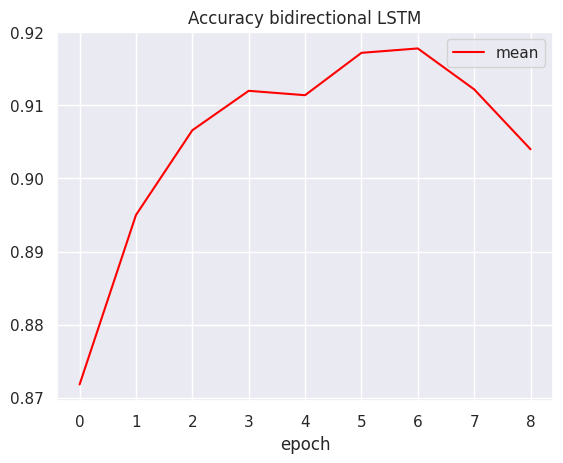

In [35]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_bd[name][1:])), acc_type_LSTM_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [39]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        logits = model_LSTM_bd(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy = {test_accuracy}')

test_accuracy = 0.9173346757888794


### Уменьшим размер скрытого слоя с 256 до 128

In [40]:
model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=128, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.2, bd=True, aggregation_type=aggregation_type).to(device)

In [41]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_bd = {}
acc_type_LSTM_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=128, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.2, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_bd.eval()
                acc_now = evaluate(model_LSTM_bd, eval_dataloader)
                acc.append(acc_now)
                model_LSTM_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_bd[aggregation_type] = losses
    acc_type_LSTM_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 7min 23s, sys: 6.12 s, total: 7min 30s
Wall time: 7min 38s


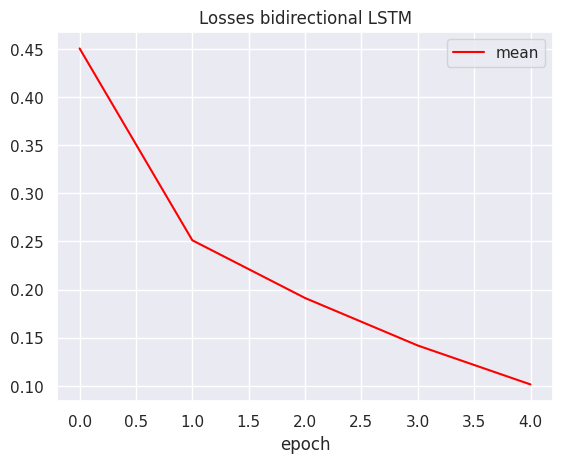

In [42]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_bd[name])), losses_type_LSTM_bd[name], color=color, label=name)

plt.title('Losses bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.14


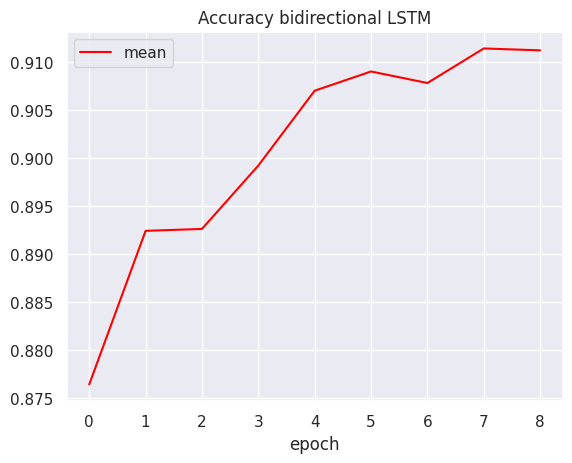

In [43]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_bd[name][1:])), acc_type_LSTM_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [44]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        logits = model_LSTM_bd(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy = {test_accuracy}')

test_accuracy = 0.9095691442489624


### Вроде, метрики теперь растут более монотонно взавиимости от эпох, попробуем увеличить их количесво

In [45]:
model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=128, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.2, bd=True, aggregation_type=aggregation_type).to(device)

In [46]:
%%time

num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_bd = {}
acc_type_LSTM_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=128, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.2, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_bd.eval()
                acc_now = evaluate(model_LSTM_bd, eval_dataloader)
                acc.append(acc_now)
                model_LSTM_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_bd[aggregation_type] = losses
    acc_type_LSTM_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 14min 46s, sys: 12.1 s, total: 14min 58s
Wall time: 15min 14s


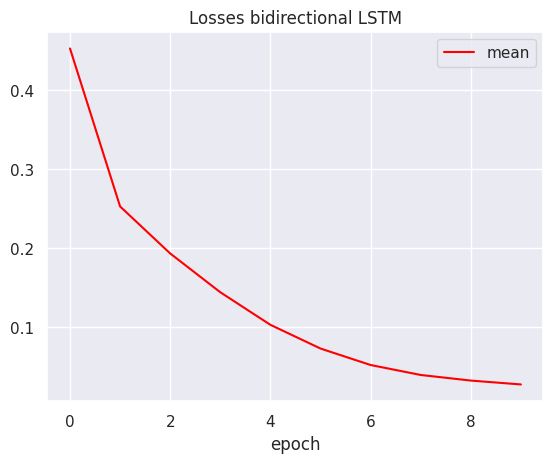

In [47]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_bd[name])), losses_type_LSTM_bd[name], color=color, label=name)

plt.title('Losses bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.86


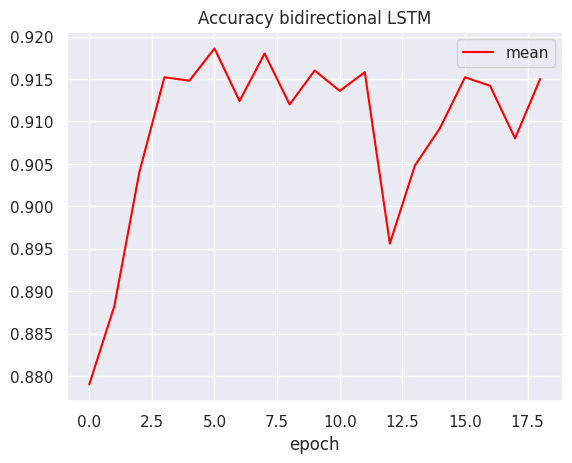

In [48]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_bd[name][1:])), acc_type_LSTM_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [49]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        logits = model_LSTM_bd(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy = {test_accuracy}')

test_accuracy = 0.9105711579322815
